In [ ]:
!pip install nsepy

In [ ]:
!pip install nvidia-smi

In [ ]:
!pip install tensorflow-gpu

In [4]:
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [7]:
one_clck_eq=['ASHOKLEY','BEL','FEDERALBNK','GPPL','JSWENERGY','SEQUENT']

In [ ]:
start = dt.datetime(2013,11,1)
end = dt.datetime(2021,12,31)
stk_data = gh(symbol='FEDERALBNK',start=start,end=end)

In [8]:
stk_data

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2013-11-01,FEDERALBNK,EQ,82.10,82.30,84.75,81.75,82.80,82.90,83.56,4362526,3.645260e+13,32340,1632958,0.3743
2013-11-03,FEDERALBNK,EQ,82.90,83.00,84.35,83.00,83.20,83.45,83.65,641357,5.364930e+12,4320,342025,0.5333
2013-11-05,FEDERALBNK,EQ,83.45,83.25,86.50,81.10,85.00,85.45,84.65,5475322,4.634700e+13,34822,2060039,0.3762
2013-11-06,FEDERALBNK,EQ,85.45,86.00,86.50,80.50,80.90,81.30,83.12,3346086,2.781118e+13,29576,1340527,0.4006
2013-11-07,FEDERALBNK,EQ,81.30,82.50,85.90,78.15,79.00,78.85,82.53,7538176,6.221266e+13,54891,2348979,0.3116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,FEDERALBNK,EQ,81.00,80.25,81.90,78.60,81.50,81.25,80.51,9405458,7.572129e+13,41536,2080195,0.2212
2021-12-28,FEDERALBNK,EQ,81.25,82.10,82.35,81.30,81.75,81.90,81.82,6676061,5.462119e+13,22801,1959454,0.2935
2021-12-29,FEDERALBNK,EQ,81.90,81.75,82.50,81.40,81.90,81.95,81.99,6029362,4.943607e+13,23937,1717937,0.2849


In [9]:
fig=px.line(stk_data['Close'],title='FEDERAL BANK HISTORICAL STOCK VALUE')
fig.show()

In [10]:
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = stk_data['Date']
data2['Open'] = stk_data['Open']
data2['High'] = stk_data['High']
data2['Low'] = stk_data['Low']
data2['Close'] = stk_data['Close']

In [11]:
x_train=data2['Close']

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [13]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



In [14]:
window_size = 5
batch_size = 50
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
#train_set1 = windowed_dataset(train_cl, window_size, batch_size, shuffle_buffer_size)

In [45]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 128)            512       
                                                                 
 lstm (LSTM)                 (None, 5, 64)             49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 62,881
Trainable params: 62,881
Non-traina

In [46]:
init_weights = model.get_weights()

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the validation set MAE
    if float(logs.get('val_mae') < 5.2):

      # Stop if threshold is met
      print("\nRequired val MAE is met so cancelling training!")
      self.model.stop_training = True

# Instantiate the class
callbacks_ = myCallback()

In [34]:
date.today()

datetime.date(2022, 10, 15)

In [35]:
dt.date(2021,10,10)

datetime.date(2021, 10, 10)

In [36]:
from datetime import date
testdataframe= gh(symbol='FEDERALBNK',start=dt.date(2021,10,10),end=date.today())
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']

In [37]:
val_set = windowed_dataset(testdata['Close'], window_size, batch_size, shuffle_buffer_size)


In [38]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100,callbacks=[lr_schedule])

Epoch 1/100
41/41 [==============================] - 5s 17ms/step - loss: 120.0870 - lr: 1.0000e-08
Epoch 2/100
41/41 [==============================] - 1s 16ms/step - loss: 111.5116 - lr: 1.1220e-08
Epoch 3/100
41/41 [==============================] - 1s 16ms/step - loss: 101.4822 - lr: 1.2589e-08
Epoch 4/100
41/41 [==============================] - 1s 17ms/step - loss: 89.9265 - lr: 1.4125e-08
Epoch 5/100
41/41 [==============================] - 1s 16ms/step - loss: 80.7300 - lr: 1.5849e-08
Epoch 6/100
41/41 [==============================] - 1s 18ms/step - loss: 75.6147 - lr: 1.7783e-08
Epoch 7/100
41/41 [==============================] - 1s 17ms/step - loss: 70.9011 - lr: 1.9953e-08
Epoch 8/100
41/41 [==============================] - 1s 16ms/step - loss: 65.8677 - lr: 2.2387e-08
Epoch 9/100
41/41 [==============================] - 1s 16ms/step - loss: 60.6497 - lr: 2.5119e-08
Epoch 10/100
41/41 [==============================] - 1s 16ms/step - loss: 55.2929 - lr: 2.8184e-08
Epoch 

(1e-08, 0.001, 0.0, 50.0)

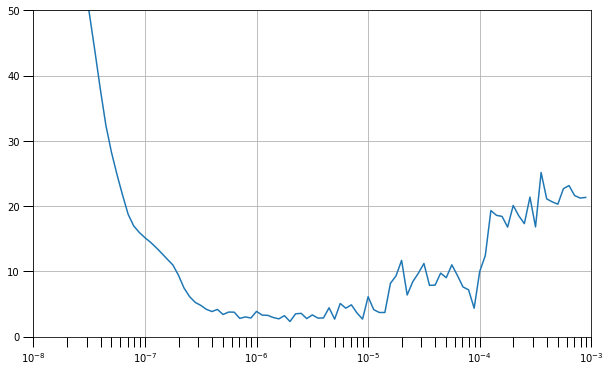

In [39]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [47]:
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [48]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=30)
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 128)            512       
                                                                 
 lstm (LSTM)                 (None, 5, 64)             49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 62,881
Trainable params: 62,881
Non-traina

In [49]:
history = model.fit(train_set,epochs=125)

Epoch 1/125
41/41 [==============================] - 7s 18ms/step - loss: 37.0118 - mae: 37.5073
Epoch 2/125
41/41 [==============================] - 1s 17ms/step - loss: 14.5945 - mae: 15.0819
Epoch 3/125
41/41 [==============================] - 1s 17ms/step - loss: 12.0561 - mae: 12.5418
Epoch 4/125
41/41 [==============================] - 1s 16ms/step - loss: 10.1018 - mae: 10.5857
Epoch 5/125
41/41 [==============================] - 1s 18ms/step - loss: 8.3618 - mae: 8.8452
Epoch 6/125
41/41 [==============================] - 1s 18ms/step - loss: 6.7640 - mae: 7.2413
Epoch 7/125
41/41 [==============================] - 1s 18ms/step - loss: 5.4971 - mae: 5.9674
Epoch 8/125
41/41 [==============================] - 1s 17ms/step - loss: 4.5986 - mae: 5.0655
Epoch 9/125
41/41 [==============================] - 1s 17ms/step - loss: 4.0358 - mae: 4.5015
Epoch 10/125
41/41 [==============================] - 1s 18ms/step - loss: 3.6187 - mae: 4.0825
Epoch 11/125
41/41 [=====================

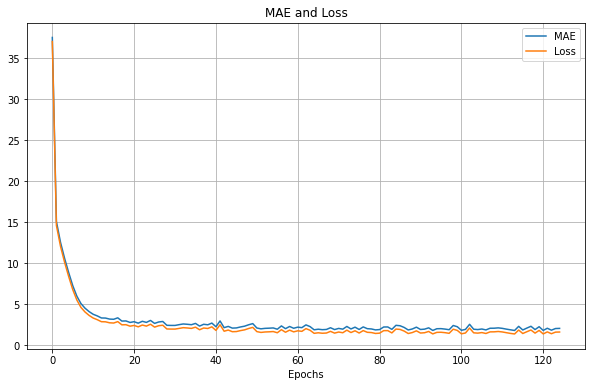

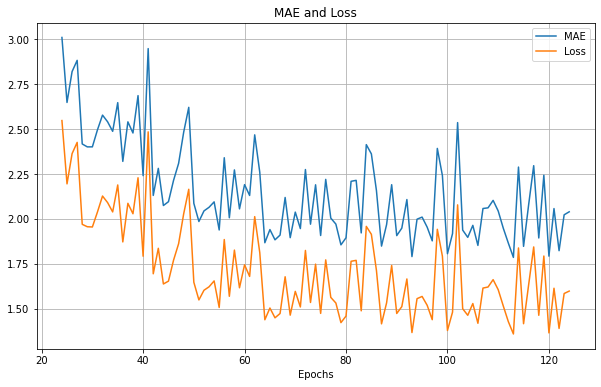

In [50]:
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

In [51]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [52]:
len(testdata)

252

In [54]:
window_size

5

Generating predictions for one week forward


In [104]:
print(f"prediction dataset day start: {testdata['Date'][247]}")
prediction_start_array=testdata['Close'][247:].values
prediction_start_array=list(prediction_start_array)

prediction dataset day start: 2022-10-10


In [105]:
testdata['Close'][248]

122.4

In [106]:
testdata.tail(10)

,Date,Open,High,Low,Close
Date,,,,,
2022-09-30,2022-09-30,112.70,119.50,111.40,118.75
2022-10-03,2022-10-03,119.35,121.50,115.90,116.30
2022-10-04,2022-10-04,118.80,121.15,118.75,120.85
2022-10-06,2022-10-06,121.45,122.20,120.40,120.85
2022-10-07,2022-10-07,120.50,123.20,118.75,122.85
2022-10-10,2022-10-10,121.00,122.00,120.10,121.35
2022-10-11,2022-10-11,121.80,124.20,121.05,122.40
2022-10-12,2022-10-12,123.30,125.90,121.80,125.60
2022-10-13,2022-10-13,125.55,126.75,124.40,124.90


In [107]:
prediction_start_array

[121.35, 122.4, 125.6, 124.9, 130.35]

In [98]:

datelist = pd.date_range(testdata['Date'][251], periods=9).tolist()

In [99]:
datelist=datelist[3:]
datelist

[Timestamp('2022-10-17 00:00:00', freq='D'),
 Timestamp('2022-10-18 00:00:00', freq='D'),
 Timestamp('2022-10-19 00:00:00', freq='D'),
 Timestamp('2022-10-20 00:00:00', freq='D'),
 Timestamp('2022-10-21 00:00:00', freq='D'),
 Timestamp('2022-10-22 00:00:00', freq='D')]

In [67]:
window_size

5

In [108]:
i=0
year_end_forecasts=[]
while i!=8:
  dataset = tf.data.Dataset.from_tensor_slices(prediction_start_array)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset)
  result=forecast.squeeze()
  print(result)
  year_end_forecasts.append(result)
  prediction_start_array.remove(prediction_start_array[0])
  prediction_start_array.append(result)
  
  i+=1



1/1 [==============================] - 0s 56ms/step
124.401215
1/1 [==============================] - 0s 50ms/step
122.526505
1/1 [==============================] - 0s 55ms/step
119.412994
1/1 [==============================] - 0s 51ms/step
116.170395
1/1 [==============================] - 0s 50ms/step
113.62338
1/1 [==============================] - 0s 51ms/step
110.93828
1/1 [==============================] - 0s 54ms/step
108.42018
1/1 [==============================] - 0s 55ms/step
105.97465


In [101]:
forecasts_array=pd.DataFrame(list(zip(datelist,year_end_forecasts)),columns=['Date','Cose'])

In [102]:
forecasts_array

,Date,Cose
0,2022-10-17,124.401215
1,2022-10-18,122.526505
2,2022-10-19,119.412994
3,2022-10-20,116.170395
4,2022-10-21,113.62338
5,2022-10-22,110.93828


In [71]:
testdata_=testdata[['Date','Close']]

In [72]:
final_total_forecasts=pd.concat([data2,testdata,testdata_])
final_total_forecasts=final_total_forecasts[['Close']]

final_total_forecasts

,Close
Date,
2013-11-01,82.90
2013-11-03,83.45
2013-11-05,85.45
2013-11-06,81.30
2013-11-07,78.85
...,...
2022-10-10,121.35
2022-10-11,122.40
2022-10-12,125.60


In [73]:
final_total_forecasts['shifted']=final_total_forecasts['Close'].shift(1).values
final_total_forecasts['shifted'].fillna(0,inplace=True)
final_total_forecasts['margin']=final_total_forecasts['Close']-final_total_forecasts['shifted']


In [74]:
final_total_forecasts['Date']=final_total_forecasts.index
final_total_forecasts['Date']=final_total_forecasts['Date'].astype('str')
#final_total_forecasts.reset_index(inplace=True)

final_total_forecasts['id']=[i for i in range(1,len(final_total_forecasts)+1)]

In [75]:
final_total_forecasts['margin'][1:]

Date
2013-11-03    0.55
2013-11-05    2.00
2013-11-06   -4.15
2013-11-07   -2.45
2013-11-08   -0.80
              ... 
2022-10-10   -1.50
2022-10-11    1.05
2022-10-12    3.20
2022-10-13   -0.70
2022-10-14    5.45
Name: margin, Length: 2522, dtype: float64

In [76]:
def calc_profit_margin(stock_buy_date):

  

  id_buy=final_total_forecasts[final_total_forecasts['Date']==stock_buy_date]['id'].values[0]
  slashed=final_total_forecasts['margin'][id_buy:].values
  
  slashed=list(slashed)
  net_profit=sum(slashed)
  
  return f'Your net profit per stock from day of purchase is Rs {net_profit}'






In [77]:
calc_profit_margin('2013-11-07')

'Your net profit per stock from day of purchase is Rs 51.5'

In [ ]:
len(year_end_forecasts)

31

In [78]:
forecast = model_forecast(model, testdata['Close'], window_size, batch_size)
results=forecast.squeeze()

len(forecast)

5/5 [==============================] - 0s 16ms/step


248

In [79]:
results

array([ 91.29165 ,  90.089645,  90.62417 ,  92.20558 ,  97.9118  ,
        99.54927 ,  98.85642 ,  96.91717 ,  95.64856 ,  94.37794 ,
        94.69829 ,  97.53305 ,  97.81659 ,  97.79329 ,  97.91161 ,
        99.015976,  97.899055,  97.188934,  96.98689 ,  96.83343 ,
        95.11775 ,  94.08663 ,  92.3882  ,  89.49828 ,  88.975525,
        89.83957 ,  90.20025 ,  86.937126,  84.30084 ,  83.48578 ,
        85.04121 ,  85.86825 ,  86.15541 ,  85.05874 ,  85.883896,
        86.95361 ,  87.80361 ,  88.73968 ,  89.102394,  88.30318 ,
        86.60051 ,  85.73746 ,  83.241776,  79.289986,  77.3529  ,
        78.010254,  79.196175,  78.54985 ,  78.1577  ,  78.58079 ,
        79.10934 ,  79.16476 ,  79.69476 ,  82.64294 ,  84.93923 ,
        86.481064,  86.57443 ,  87.77256 ,  90.72754 ,  93.017426,
        94.65658 ,  96.32106 ,  96.855965,  96.668816,  95.65455 ,
        95.50268 ,  94.94799 ,  92.29337 ,  89.31982 ,  91.07798 ,
        95.35591 ,  97.2443  ,  97.08026 ,  96.93308 ,  97.976

In [80]:
testdata['Close'][:229]

Date
2021-10-11     86.25
2021-10-12     88.60
2021-10-13     93.60
2021-10-14     93.10
2021-10-18     95.30
               ...  
2022-09-06    121.20
2022-09-07    118.75
2022-09-08    118.05
2022-09-09    119.55
2022-09-12    119.80
Name: Close, Length: 229, dtype: float64

In [81]:
initial_forecasts=pd.DataFrame(list(zip(testdata['Date'][:239].values,testdata['Close'][:239].values,results)),columns=['date','actual','predicted'])
initial_forecasts.set_index('date',inplace=True)
initial_forecasts

,actual,predicted
date,,
2021-10-11,86.25,91.291649
2021-10-12,88.60,90.089645
2021-10-13,93.60,90.624168
2021-10-14,93.10,92.205582
2021-10-18,95.30,97.911797
...,...,...
2022-09-20,123.30,109.105789
2022-09-21,122.75,109.038673
2022-09-22,122.90,109.160950


In [82]:

print(f"RMSE:{np.sqrt(tf.keras.metrics.mean_squared_error(initial_forecasts['actual'], initial_forecasts['predicted']).numpy())}")
print(f"MAE:{tf.keras.metrics.mean_absolute_error(initial_forecasts['actual'], initial_forecasts['predicted']).numpy()}")

RMSE:4.753878116607666
MAE:3.7952964305877686


In [83]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=initial_forecasts.index,y=initial_forecasts['actual'],name='actual', mode="lines"))
fig.add_trace(go.Scatter(x=initial_forecasts.index,y=initial_forecasts['predicted'],name='predicted', mode="lines"))

In [84]:
saved_yr_end=[]
for i in year_end_forecasts:
  saved_yr_end.append(float(i))

#saved_yr_end

In [85]:
all_future_predicted=list(initial_forecasts['predicted'][:238].values)+saved_yr_end
all_actual=list(testdata['Close'].values)

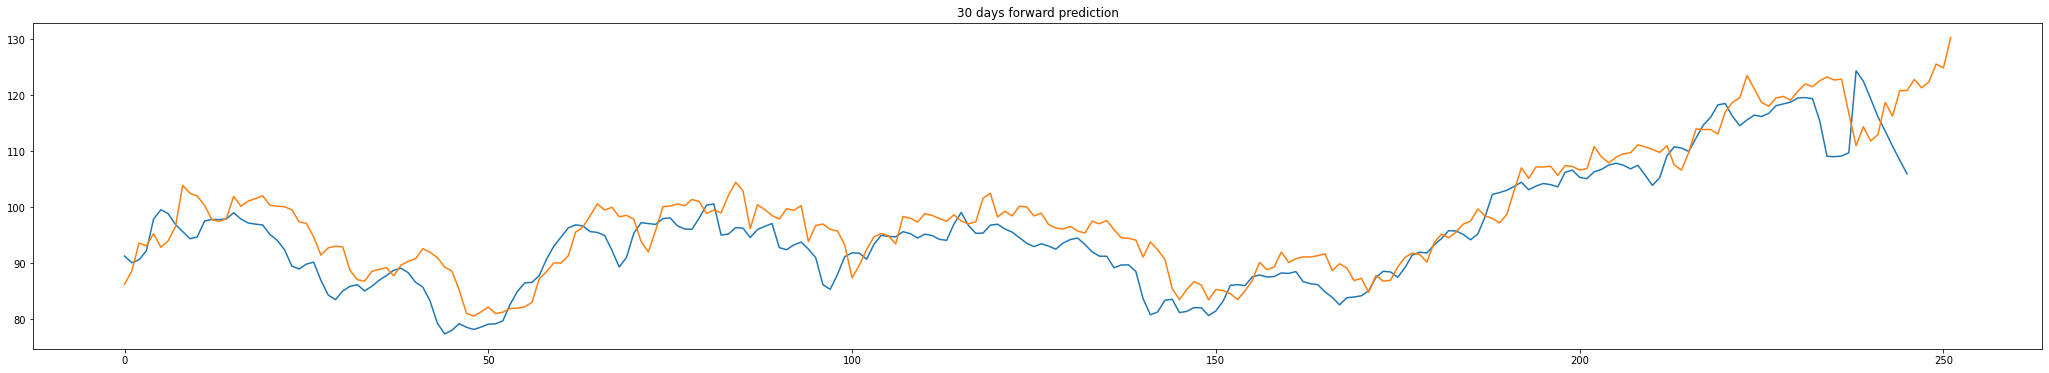

In [86]:
plt.figure(figsize=(36,6))
plt.title('')
plt.plot(all_future_predicted)
plt.plot(all_actual)
plt.title('30 days forward prediction')
plt.show()